# IFN703: Exploratory Data Analysis

## Libraries

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.layers import Dense, Conv1D, BatchNormalization, Dropout, Flatten, Input, Concatenate, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

import pandas as pd
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from biosppy.signals import ecg
from scipy import signal as ss

from keras.utils import model_to_dot, plot_model

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from collections import Counter

import warnings

warnings.filterwarnings('ignore')

# Data

## EDA CSV files

In [3]:
train_data = pd.read_csv('./data/training.csv')
test_data = pd.read_csv('./data/testing.csv')

print("Training DataFrame:")
print(train_data.head())

print("\nTesting DataFrame:")
print(test_data.head())

Training DataFrame:
  filename   label
0   A01823  normal
1   A05482  normal
2   A06114  normal
3   A04275  normal
4   A01157  normal

Testing DataFrame:
  filename   label
0   A02083  normal
1   A08474  normal
2   A03133  normal
3   A01743  normal
4   A06930  normal


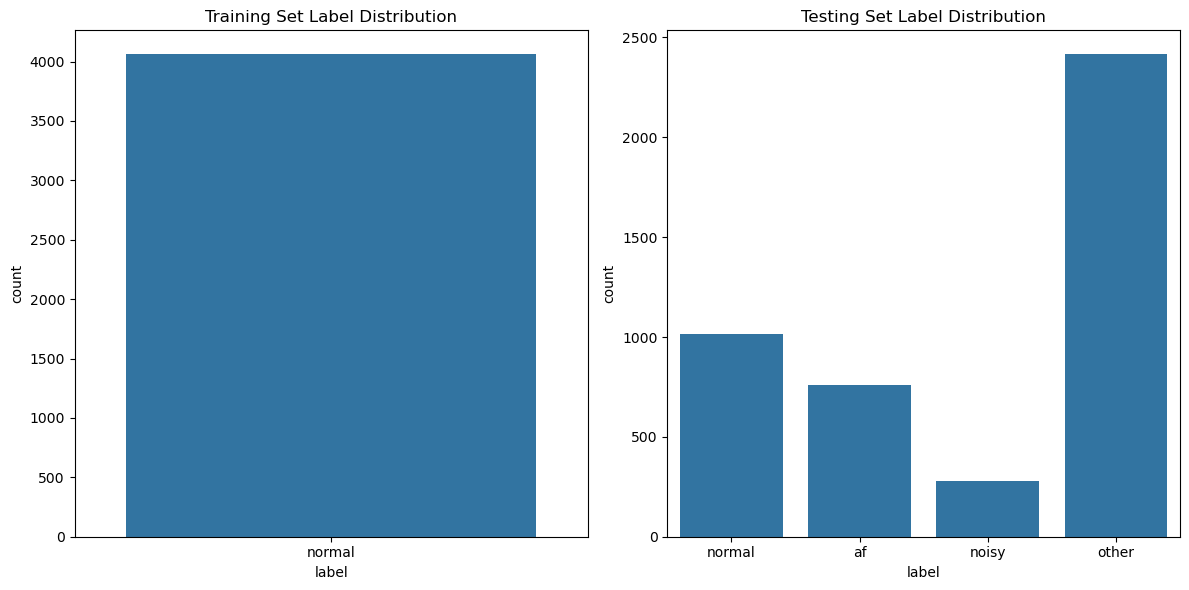

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(ax=axes[0], x='label', data=train_data)
axes[0].set_title('Training Set Label Distribution')

sns.countplot(ax=axes[1], x='label', data=test_data)
axes[1].set_title('Testing Set Label Distribution')

plt.tight_layout()
plt.show()

## EDA: Training and Testing folders

#### Data shapes

In [5]:
def count_mat_files(training_path, testing_path):
    training_count = len([name for name in os.listdir(training_path) if name.endswith('.mat')])
    
    testing_count = len([name for name in os.listdir(testing_path) if name.endswith('.mat')])
    
    return training_count, testing_count

In [6]:
training_dir = "./data/training/"
testing_dir = "./data/testing/"

training_count, testing_count = count_mat_files(training_dir, testing_dir)
print("Number of .mat files in training directory:", training_count)
print("Number of .mat files in testing directory:", testing_count)

Number of .mat files in training directory: 4060
Number of .mat files in testing directory: 4468


In [7]:
mat_data = scipy.io.loadmat('data/training/A00001.mat')

data_shape = mat_data['val'].shape

print("Shape of the data in the .mat file:", data_shape)

Shape of the data in the .mat file: (1, 9000)


In [8]:
def get_min_max_shape(directory):
    min_shape = None
    max_shape = None
    
    for filename in os.listdir(directory):
        if filename.endswith(".mat"):
            filepath = os.path.join(directory, filename)
            try:
                mat_data = scipy.io.loadmat(filepath)
                data_shape = mat_data['val'].shape
                
                if min_shape is None or data_shape < min_shape:
                    min_shape = data_shape
                if max_shape is None or data_shape > max_shape:
                    max_shape = data_shape
            except Exception as e:
                print(f"Error loading file {filepath}: {e}")

    return min_shape, max_shape

training_dir = "./data/training/"

min_shape, max_shape = get_min_max_shape(training_dir)

print("Minimum shape in the training folder:", min_shape)
print("Maximum shape in the training folder:", max_shape)


'''Minimum shape in the training folder: (1, 2714)
# Maximum shape in the training folder: (1, 18286)'''


Minimum shape in the training folder: (1, 2714)
Maximum shape in the training folder: (1, 18286)


'Minimum shape in the training folder: (1, 2714)\n# Maximum shape in the training folder: (1, 18286)'

In [9]:
def get_signal_lengths(directory):
    lengths = []
    file_list = [f for f in os.listdir(directory) if f.endswith(".mat")]

    for filename in tqdm(file_list, desc=f"Processing {directory}"):
        filepath = os.path.join(directory, filename)
        try:
            mat_data = scipy.io.loadmat(filepath)
            ecg_signal = mat_data['val']
            signal_length = ecg_signal.shape[1]  
            lengths.append(signal_length)
        except Exception as e:
            print(f"Error loading file {filepath}: {e}")
    
    return lengths

In [10]:
def plot_signal_lengths(data_lengths):
    
    data_counter = Counter(train_lengths)
    
    data_lengths, data_counter = zip(*sorted(data_counter.items()))

    plt.figure(figsize=(12, 6))
    
    plt.hist(data_lengths, bins=50, alpha=0.7)
    
    plt.xlabel('Signal Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of ECG Signal Lengths in Training and Testing Datasets')
    plt.legend(loc='upper right')
    
    plt.show()

In [11]:
training_dir = "./data/training/"
testing_dir = "./data/testing/"

train_lengths = get_signal_lengths(training_dir)
test_lengths = get_signal_lengths(testing_dir)

print("Training signal lengths:", train_lengths[:5])  
print("Testing signal lengths:", test_lengths[:5])  

Processing ./data/testing/: 100%|██████████| 4468/4468 [00:07<00:00, 614.28it/s]

Training signal lengths: [9000, 9000, 9000, 9000, 5364]
Testing signal lengths: [9000, 9000, 9000, 9300, 9000]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


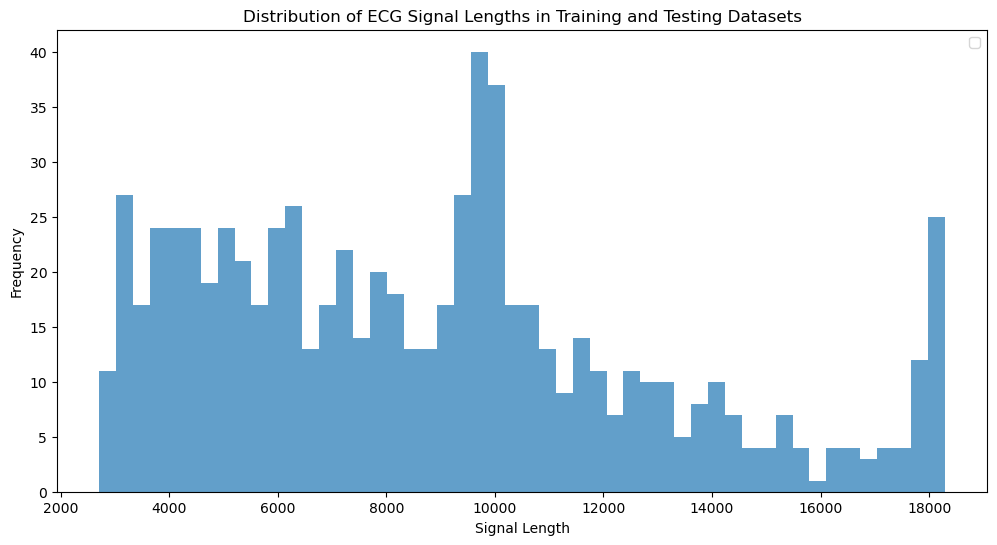

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


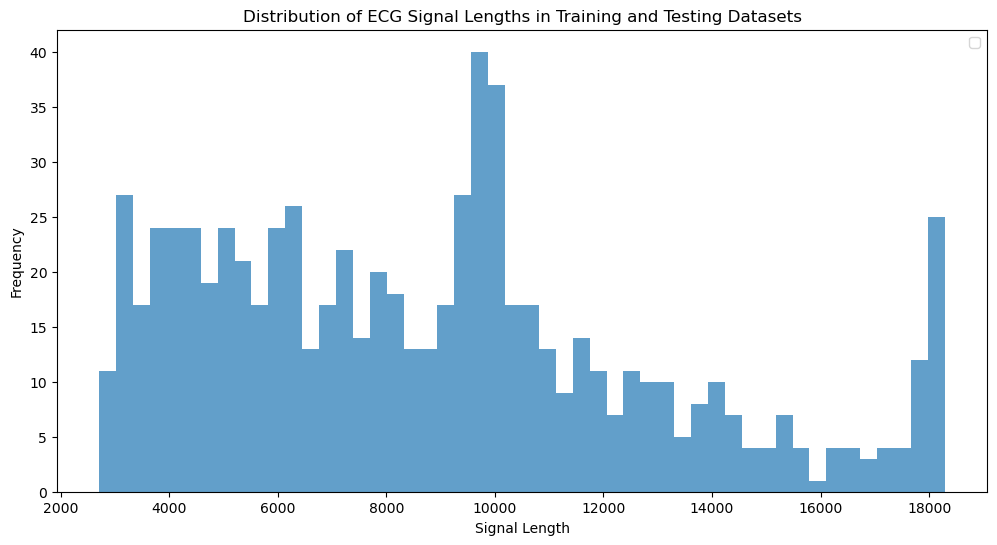

In [12]:
plot_signal_lengths(train_lengths)
plot_signal_lengths(test_lengths)

In [13]:
train_lengths_counter = Counter(train_lengths)
train_lengths_counter_filtered = Counter({length: count for length, count in train_lengths_counter.items() if length >= 9000})

test_lengths_counter = Counter(test_lengths)
test_lengths_counter_filtered = Counter({length: count for length, count in test_lengths_counter.items() if length >= 9000})

Training_total_count_greater_than_9000 = sum(train_lengths_counter_filtered.values())
print("Total number of ECG signals with lengths >= greater than 9000:", Training_total_count_greater_than_9000)
    
Testing_total_count_greater_than_9000 = sum(test_lengths_counter_filtered.values())
print("Total number of ECG signals with lengths >= than 9000:", Testing_total_count_greater_than_9000)


Total number of ECG signals with lengths >= greater than 9000: 3631
Total number of ECG signals with lengths >= than 9000: 3930


In [14]:
file_path = "./data/training/A08218.mat" 

mat_data = scipy.io.loadmat(file_path)

print("Keys in the .mat file:", mat_data.keys())


Keys in the .mat file: dict_keys(['val'])


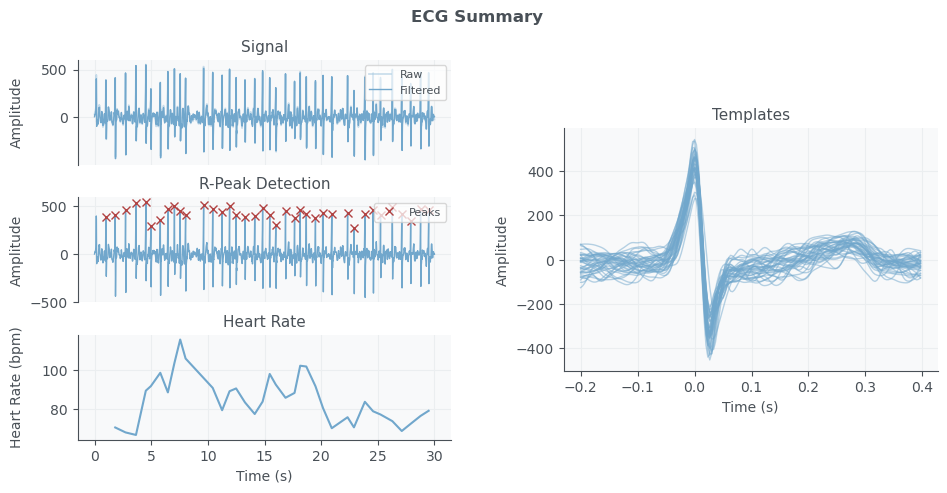

In [15]:
mat_data = scipy.io.loadmat('data/testing/A08154.mat')  

ecg_data = mat_data['val'].flatten()  

rpeaks = ecg.ecg(signal=ecg_data, sampling_rate=300)['rpeaks']

# Data Preparation

In [16]:
def mat_to_numpy(directory, output_directory, signal_length=9000):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Get the total number of files for the progress bar
    total_files = sum(1 for filename in os.listdir(directory) if filename.endswith(".mat"))
    
    # Initialize the progress bar
    pbar = tqdm(total=total_files, desc="Converting .mat files")
    
    file_count = 0

    for filename in os.listdir(directory):
        if filename.endswith(".mat"):
            filepath = os.path.join(directory, filename)
            try:
                mat_data = scipy.io.loadmat(filepath)
                ecg_signal = mat_data['val'][0]
                
                if len(ecg_signal) >= signal_length:
                    ecg_signal = ecg_signal[:signal_length]
                elif len(ecg_signal) == signal_length:
                    pass  # Do nothing, signal length is already 9000
                else:
                    continue  # Skip files with signal length less than 9000
                    
                output_filepath = os.path.join(output_directory, filename.replace('.mat', '.npy'))
                np.save(output_filepath, ecg_signal)

                # Print the filename and its corresponding label for the first 5 files
                if file_count < 5:
                    print(f"File: {filename}")

                file_count += 1
                
                pbar.update(1)  # Update progress bar for each file processed

            except Exception as e:
                print(f"Error converting file {filepath}: {e}")
            

    
    pbar.close()

training_dir = "./data/training/"
testing_dir = "./data/testing/"

output_training_dir = "./data/training_np/"
output_testing_dir = "./data/testing_np/"

mat_to_numpy(training_dir, output_training_dir)
mat_to_numpy(testing_dir, output_testing_dir)


In [17]:
def check_signal_length(directory, expected_length=9000):
    total_files = sum(1 for filename in os.listdir(directory) if filename.endswith(".npy"))
    
    pbar = tqdm(total=total_files, desc=f"Checking signal length in {directory} directory")
    
    total_elements = 0
    less_than_expected = 0
    
    for filename in os.listdir(directory):
        if filename.endswith(".npy"):
            filepath = os.path.join(directory, filename)
            try:
                signal = np.load(filepath)
                total_elements += 1
                
                if len(signal) != expected_length:
                    less_than_expected += 1
                
                pbar.update(1)
            except Exception as e:
                print(f"Error loading file {filepath}: {e}")
    
    pbar.close()
    
    print(f"Total number of elements in {directory}: {total_elements}")
    print(f"Number of files with length less or more than {expected_length} in {directory}: {less_than_expected}")

check_signal_length("./data/testing_np")

check_signal_length("./data/training_np")


In [18]:
def save_signals_individually(input_directory, output_directory, label_df):
    os.makedirs(output_directory, exist_ok=True)
    
    pbar = tqdm(total=len(os.listdir(input_directory)), desc="Saving signals")
    
    file_count = 0
    
    for filename in os.listdir(input_directory):
        if filename.endswith(".npy"):
            filepath = os.path.join(input_directory, filename)
            try:
                ecg_signal = np.load(filepath)
                label = label_df.loc[label_df['filename'] == filename[:-4], 'label'].values[0]
                
                output_filepath = os.path.join(output_directory, filename.replace('.npy', '.npz'))
                np.savez(output_filepath, signal=ecg_signal, label=label)
                
                if file_count < 5:
                    print(f"File: {filename}, Label: {label}")
                
                file_count += 1
                
                pbar.update(1)
            except Exception as e:
                print(f"Error loading file {filepath}: {e}")
    
    pbar.close()

In [19]:
training_dir = "./data/training_np/"
testing_dir = "./data/testing_np/"
training_labels_df = pd.read_csv('./data/training.csv')
testing_labels_df = pd.read_csv('./data/testing.csv')

train_output_dir = './data/train_npz'
test_output_dir = './data/test_npz'

save_signals_individually(training_dir, train_output_dir, training_labels_df)

save_signals_individually(testing_dir, test_output_dir, testing_labels_df)

In [20]:
def load_individual_npz_files(directory, signal_length):
    X = []
    y = []
    
    file_count = 0
    
    pbar = tqdm(total=len(os.listdir(directory)), desc="Loading data")
    
    for filename in os.listdir(directory):
        if filename.endswith(".npz"):
            filepath = os.path.join(directory, filename)
            try:
                data = np.load(filepath)
                ecg_signal = data['signal']
                label = data['label']
                
                if len(ecg_signal) < signal_length:
                    ecg_signal = np.pad(ecg_signal, (0, signal_length - len(ecg_signal)), 'constant')
                elif len(ecg_signal) > signal_length:
                    ecg_signal = ecg_signal[:signal_length]
                
                X.append(ecg_signal)
                y.append(label)
                
                if file_count < 5:
                    print(f"File: {filename}, Label: {label}")
                
                file_count += 1
                
                pbar.update(1)
            except Exception as e:
                print(f"Error loading file {filepath}: {e}")
    
    pbar.close()
    
    return np.array(X), np.array(y)

In [21]:
signal_length = 9000

x_train, y_train = load_individual_npz_files('./data/train_npz', signal_length)
x_test, y_test = load_individual_npz_files('./data/test_npz', signal_length)

print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)

print("Data saved successfully.")

-----------